In [ ]:
!pip install -r requirements.txt

In [ ]:
# !pip install wandb==0.19.6+computecanada

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Dinov2Model, SegformerForSemanticSegmentation
from safetensors.torch import load_file
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.checkpoint import checkpoint as torch_checkpoint
from torchmetrics import MeanMetric
from PIL import Image
import os
import numpy as np
from dataclasses import dataclass
import random
from tqdm import tqdm
import time
import wandb

In [2]:
wandb.login(key="4f8dccbaced16f201316dd4113139739694dfd3b") 

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/saahmed/.netrc
wandb: Currently logged in as: salmagg (my_research_projects) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(project="joint-training",
          name="joint-training_experiment2")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [4]:
# ----------------------------
# Model Definitions
# ----------------------------

class SimCLR(nn.Module):
    def __init__(self, dropout_p=0.5, embedding_size=128, freeze=False, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        self.dropout_p = dropout_p
        self.embedding_size = embedding_size
        self.encoder = Dinov2Model.from_pretrained('microsoft/rad-dino')
        
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.projection = nn.Sequential(
            nn.Linear(768, 256),
            nn.Dropout(p=self.dropout_p),
            nn.ReLU(),
            nn.Linear(256, embedding_size)
        )

    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        outputs = self.encoder(x)
        encoding = outputs.last_hidden_state[:, 0]
        projection = self.projection(encoding)
        return projection

retrieval_checkpoint = '/home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/simclr_rad-dino_pos-pairs_aug-pairs_epochs100/best_model/'

retrieval_model = SimCLR(dropout_p=0.3, embedding_size=128, freeze=False, linear_eval=True)
encoder_state_dict = load_file(os.path.join(retrieval_checkpoint, 'model.safetensors'))
retrieval_model.encoder.load_state_dict(encoder_state_dict)
projection_state_dict = torch.load(os.path.join(retrieval_checkpoint, 'projection_head.pth'), map_location=torch.device('cpu'))
retrieval_model.projection.load_state_dict(projection_state_dict)

/tmp/ipykernel_3299395/2775795213.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  projection_state_dict = torch.load(os.path.join(retrieval_checkpoint, 'projection_head

<All keys matched successfully>

In [5]:
class JointSegmentationModel(nn.Module):
    def __init__(self, base_model, composite_in_channels=11):
        super().__init__()
        # Map composite input channels to 3 channels expected by segformer
        self.input_adapter = nn.Conv2d(composite_in_channels, 3, kernel_size=1)
        self.base_model = base_model

    def forward(self, x):
        x = self.input_adapter(x)
        outputs = self.base_model(pixel_values=x, return_dict=True)
        # Upsample logits to match input resolution
        logits = F.interpolate(outputs["logits"], size=x.shape[-2:], mode="bilinear", align_corners=False)
        return logits

def dice_coef_loss(predictions, ground_truths, num_classes=4, dims=(1, 2), smooth=1e-8):
    ground_truth_oh = F.one_hot(ground_truths, num_classes=num_classes)
    prediction_norm = F.softmax(predictions, dim=1).permute(0, 2, 3, 1)
    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)
    dice = (2.0 * intersection + smooth) / (summation + smooth)
    dice_mean = dice.mean()
    CE = F.cross_entropy(predictions, ground_truths)
    return (1.0 - dice_mean) + CE

def differentiable_top2(similarity, tau=1.0):
    weights1 = F.gumbel_softmax(similarity, tau=tau, hard=True)
    B, N = similarity.shape
    masked_similarity = similarity.clone()
    indices = weights1.argmax(dim=-1, keepdim=True)
    for i in range(B):
        masked_similarity[i, indices[i]] = float('-inf')
    weights2 = F.gumbel_softmax(masked_similarity, tau=tau, hard=True)
    return weights1, weights2

In [44]:
class JointTrainingModule(nn.Module):
    def __init__(self, retrieval_model, segmentation_model, num_classes=4, lr=1e-4):
        super().__init__()
        self.retrieval_model = retrieval_model
        self.segmentation_model = segmentation_model
        self.lr = lr
        self.num_classes = num_classes

    def forward(self, query_image, gallery_images, gallery_masks):
        # Compute query embedding
        query_embedding = self.retrieval_model(query_image)
        B, N, C, H, W = gallery_images.shape
        gallery_images_flat = gallery_images.view(B * N, C, H, W)

        gallery_embeddings_list = []
        
        def compute_embedding(x):
            return self.retrieval_model(x)
        
        print('Calculating Embeddings')
        start_time = time.time()
        tempbatch_size = 70
        for i in range(0, B * N, tempbatch_size):
            batch = gallery_images_flat[i:i + tempbatch_size]
            emb = torch_checkpoint(compute_embedding, batch, use_reentrant=False)
            # emb = self.retrieval_model(batch)
            gallery_embeddings_list.append(emb)
        print('Finished Calculating Embeddings')
        
        gallery_embeddings_flat = torch.cat(gallery_embeddings_list, dim=0)
        emb_dim = gallery_embeddings_flat.shape[1]
        gallery_embeddings = gallery_embeddings_flat.view(B, N, emb_dim)
        end_time = time.time()
        print(f"Calculating Embeddings Time: {end_time - start_time:.4f} seconds\n")


        
        print('Calculating similarity')
        start_time = time.time()
        similarity = F.cosine_similarity(query_embedding.unsqueeze(1), gallery_embeddings, dim=-1)
        end_time = time.time()
        print('Finished Calculating similarity')
        print(f"Calculating similarity Time: {end_time - start_time:.4f} seconds\n")
        

        print('Calculating differentiable top2')
        start_time = time.time()
        weights1, weights2 = differentiable_top2(similarity, tau=1.0)
        end_time = time.time()
        print('Finished Calculating differentiable top2')
        print(f"Calculating differentiable top2 Time: {end_time - start_time:.4f} seconds\n")
        

        print('Calculating einsum')
        start_time = time.time()
        guide_image1 = torch.einsum('bn,bnchw->bchw', weights1, gallery_images)
        guide_image2 = torch.einsum('bn,bnchw->bchw', weights2, gallery_images)
        guide_mask1 = torch.einsum('bn,bnhw->bhw', weights1, gallery_masks.float())
        guide_mask2 = torch.einsum('bn,bnhw->bhw', weights2, gallery_masks.float())
        end_time = time.time()
        print('Finished Calculating einsum')
        print(f"Calculating einsum Time: {end_time - start_time:.4f} seconds\n")
        return guide_image1, guide_image2, guide_mask1, guide_mask2

In [7]:
# ## segmentation preparation

# Mean_per_channel = [0.15452379, 0.15452379, 0.15452379]
# Std_per_channel = [0.17455664 ,0.17455664, 0.17455664]

# def segmentation_transforms(is_train, mean, std):
#     transforms = []

#     if is_train:
#         transforms.extend([
#             A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
#             A.ShiftScaleRotate(scale_limit=0.12, rotate_limit=0.15, shift_limit=0.12, p=0.5),
#             A.RandomBrightnessContrast(p=0.5),
#             A.CoarseDropout(max_holes=8, max_height=self.img_size[1]//20, max_width=self.img_size[0]//20, min_holes=5, fill_value=0, mask_fill_value=0, p=0.5)
#         ])

#     # Preprocess transforms - Normalization and converting to PyTorch tensor format (HWC --> CHW).
#     transforms.extend([
#             A.Normalize(mean=mean, std=std, always_apply=True),
#             ToTensorV2(),  # (H, W, C) --> (C, H, W)
#     ])
#     return A.Compose(transforms)
    
# segmenent_transforms = segmentation_transforms(Mean_per_channel,Std_per_channel)


# def load_file_segmenent(file_path, depth=0):
#     file = cv2.imread(file_path, depth)
#     if depth == cv2.IMREAD_COLOR:
#         file = file[:, :, ::-1]
#     return cv2.resize(file, ((256,256)), interpolation=cv2.INTER_NEAREST)
 
# #     def __getitem__(self, index):
# #         # Load image and mask file.
# #         image = self.load_file(self.image_paths[index], depth=cv2.IMREAD_COLOR)
# #         mask  = self.load_file(self.mask_paths[index],  depth=cv2.IMREAD_GRAYSCALE)
# #         # Apply Preprocessing (+ Augmentations) transformations to image-mask pair
# #         transformed = self.transforms(image=image, mask=mask)
# #         image, mask = transformed["image"], transformed["mask"].to(torch.long)
# #         return image, mask

In [7]:
# ----------------------------
# Data Preparation
# ----------------------------
def convert_to_rgb(img):
    return img.convert("RGB")
    
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(convert_to_rgb),
    transforms.ToTensor(),
])

def remap_labels(target, mapping={0: 0, 85: 1, 170: 2, 255: 3}):
    remapped_target = torch.zeros_like(target, dtype=torch.long)
    for original_label, new_label in mapping.items():
        remapped_target[target == original_label] = new_label
    return remapped_target

# (Paths and file loading logic)
image_dir_ed = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/images/'
mask_dir_ed = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/ed/masks/'
image_dir_es = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/images/'
mask_dir_es = '/home/saahmed/scratch/projects/Image-segmentation/datasets/ACDC/processed_data/Training/es/masks/'

image_filenames = sorted([os.path.join(image_dir_ed, i) for i in os.listdir(image_dir_ed)]) + \
                  sorted([os.path.join(image_dir_es, i) for i in os.listdir(image_dir_es)])
mask_filenames = sorted([os.path.join(mask_dir_ed, i) for i in os.listdir(mask_dir_ed)]) + \
                 sorted([os.path.join(mask_dir_es, i) for i in os.listdir(mask_dir_es)])

import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def is_mask_empty(mask):
    return np.all(mask == 255)

valid_images = []
valid_masks = []
for img_path, mask_path in tqdm(zip(image_filenames, mask_filenames), total=len(image_filenames)):
    if not os.path.exists(mask_path):
        continue
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue
    if is_mask_empty(mask):
        continue
    valid_images.append(img_path)
    valid_masks.append(mask_path)

print("Total valid image-mask pairs:", len(valid_images))

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    valid_images, valid_masks, test_size=0.2, random_state=42
)
print("Number of training pairs:", len(train_imgs))
print("Number of validation pairs:", len(val_imgs))

# Prepare guide database (we use a subset for demonstration)
database_images = []
database_masks = []
for img, mask in tqdm(zip(valid_images, valid_masks), total=len(valid_images)):
    g_img = Image.open(img)
    g_mask = Image.open(mask).convert('L')
    processed_img = preprocess(g_img)
    g_mask = g_mask.resize((256,256), resample=Image.NEAREST)
    g_mask = torch.from_numpy(np.array(g_mask)).long()
    g_mask = remap_labels(g_mask)
    database_images.append(processed_img)
    database_masks.append(g_mask)
database_images = torch.stack(database_images, dim=0)
database_masks = torch.stack(database_masks, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1902/1902 [03:24<00:00,  9.29it/s]


Total valid image-mask pairs: 1841
Number of training pairs: 1472
Number of validation pairs: 369


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1841/1841 [02:03<00:00, 14.96it/s]


In [8]:
class JointMedicalDataset(Dataset):
    def __init__(self, image_file_names, mask_file_names, database_images, database_masks, image_size=(256, 256)):
        self.database_images = database_images
        self.database_masks = database_masks
        self.image_filenames = image_file_names
        self.mask_filenames  = mask_file_names
        self.image_size = image_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        query_image_path = self.image_filenames[idx]
        query_mask_path = self.mask_filenames[idx]
        query_image = Image.open(query_image_path)
        query_mask = Image.open(query_mask_path).convert('L')
        query_mask = query_mask.resize(self.image_size, resample=Image.NEAREST)
        query_image = preprocess(query_image)
        query_mask = torch.from_numpy(np.array(query_mask)).long()
        query_mask = remap_labels(query_mask)
        
        return query_image, query_mask, self.database_images, self.database_masks

In [9]:
@dataclass(frozen=True)
class Paths:
    DATA_TRAIN_IMAGES = train_imgs
    DATA_TRAIN_LABELS = train_masks
    DATA_VALID_IMAGES = val_imgs
    DATA_VALID_LABELS = val_masks
    Guide_database_imgs = database_images
    Guide_database_masks = database_masks

# Create datasets and dataloaders
train_ds = JointMedicalDataset(Paths.DATA_TRAIN_IMAGES, Paths.DATA_TRAIN_LABELS,
                               Paths.Guide_database_imgs, Paths.Guide_database_masks)
valid_ds = JointMedicalDataset(Paths.DATA_VALID_IMAGES, Paths.DATA_VALID_LABELS,
                               Paths.Guide_database_imgs, Paths.Guide_database_masks)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_ds, batch_size=4, shuffle=False)

In [ ]:
# ----------------------------
# Segmentation Model Setup
# ----------------------------
ckpt_path = '/scratch/saahmed/projects/Image-segmentation/segmentation/lightning_logs/version_0/checkpoints/ckpt_053-vloss_0.1769_vf1_0.9259.ckpt'
checkpoint = torch.load(ckpt_path, map_location="cuda:0")
state_dict = checkpoint["state_dict"]
new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}
config = SegformerForSemanticSegmentation.config_class.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")
config.num_labels = 4
segformer_base = SegformerForSemanticSegmentation(config)
segformer_base.load_state_dict(new_state_dict)
segmentation_model = JointSegmentationModel(segformer_base, composite_in_channels=11)


In [ ]:
# ----------------------------
# Instantiate Joint Module and Optimizer
# ----------------------------
joint_module = JointTrainingModule(retrieval_model, segmentation_model, num_classes=4, lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
joint_module.to(device)

In [ ]:
optimizer = torch.optim.Adam(joint_module.parameters(), lr=joint_module.lr)

In [21]:
# joint_module.half()  # Convert all parameters to FP16

In [22]:
# # ----------------------------
# # Training and Validation Loops
# # ----------------------------

# def train_one_epoch(model, dataloader, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     for batch in tqdm(dataloader, desc="Training"):
#         query_image, query_mask, gallery_images, gallery_masks = batch
#         # Move tensors to device
#         query_image = query_image.to(device).half()
#         query_mask = query_mask.to(device)
#         gallery_images = gallery_images.to(device).half()
#         gallery_masks = gallery_masks.to(device)
        
#         # Retrieve guide images/masks
#         guide_image1, guide_image2, guide_mask1, guide_mask2 = model(query_image, gallery_images, gallery_masks)
#         # Form composite input: query (3) + guide1 (3) + guide2 (3) + guide_mask1 (1) + guide_mask2 (1) = 11 channels
#         composite_input = torch.cat([
#             query_image,
#             guide_image1,
#             guide_image2,
#             guide_mask1.unsqueeze(1),
#             guide_mask2.unsqueeze(1)
#         ], dim=1)
#         # Forward pass through segmentation model
#         print(f"Calculating Loss\n")
        
#         start_time = time.time()
#         pred_masks = segmentation_model(composite_input) 
#         pred_masks_fp32 = pred_masks.float()
#         loss = dice_coef_loss(pred_masks_fp32, query_mask, num_classes=model.num_classes)
#         # loss = dice_coef_loss(pred_masks, query_mask, num_classes=model.num_classes)
#         end_time = time.time()
        
#         print(f"Calculating Loss Time: {end_time - start_time:.4f} seconds\n")
        
#         print(f"Running optimizer\n")
#         start_time = time.time()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         end_time = time.time()
#         print(f"Running optimizer Time: {end_time - start_time:.4f} seconds\n")
#         running_loss += loss.item() * composite_input.size(0)
#         # Clear cache after each batch
#         torch.cuda.empty_cache()
#         print(f"Batch Loss: {running_loss}\n")   
#     epoch_loss = running_loss / len(dataloader.dataset)
#     return epoch_loss

# def validate(model, dataloader, device):
#     model.eval()
#     running_loss = 0.0
#     with torch.no_grad():
#         for batch in tqdm(dataloader, desc="Validation"):
#             query_image, query_mask, gallery_images, gallery_masks = batch
#             query_image = query_image.to(device).half()
#             query_mask = query_mask.to(device)
#             gallery_images = gallery_images.to(device).half()
#             gallery_masks = gallery_masks.to(device)
            
#             guide_image1, guide_image2, guide_mask1, guide_mask2 = model(query_image, gallery_images, gallery_masks)
#             composite_input = torch.cat([
#                 query_image,
#                 guide_image1,
#                 guide_image2,
#                 guide_mask1.unsqueeze(1),
#                 guide_mask2.unsqueeze(1)
#             ], dim=1)
#             pred_masks = segmentation_model(composite_input)
#             loss = dice_coef_loss(pred_masks, query_mask, num_classes=model.num_classes)
#             running_loss += loss.item() * composite_input.size(0)
#     epoch_loss = running_loss / len(dataloader.dataset)
#     return epoch_loss

In [ ]:

def train_one_epoch(model, dataloader, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    for batch in tqdm(dataloader, desc="Training"):
        query_image, query_mask, gallery_images, gallery_masks = batch
        # Move tensors to device (no manual half-casting)
        query_image = query_image.to(device)
        query_mask = query_mask.to(device)
        gallery_images = gallery_images.to(device)
        gallery_masks = gallery_masks.to(device)
        
        # Forward pass with autocast
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            # Retrieve guide images/masks
            guide_image1, guide_image2, guide_mask1, guide_mask2 = model(query_image, gallery_images, gallery_masks)
            # Form composite input: query (3) + guide1 (3) + guide2 (3) + guide_mask1 (1) + guide_mask2 (1) = 11 channels
            composite_input = torch.cat([
                query_image,
                guide_image1,
                guide_image2,
                guide_mask1.unsqueeze(1),
                guide_mask2.unsqueeze(1)
            ], dim=1)
            # Forward pass through segmentation model
            print("Calculating Loss")
            start_time = time.time()
            pred_masks = model.segmentation_model(composite_input)
            # Optionally, if needed you can convert logits to FP32 here:
            # pred_masks = pred_masks.float()
            loss = dice_coef_loss(pred_masks, query_mask, num_classes=model.num_classes)
            end_time = time.time()
            print(f"Calculating Loss Time: {end_time - start_time:.4f} seconds\n")
        
        print("Running optimizer")
        start_time = time.time()
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        end_time = time.time()
        print(f"Running optimizer Time: {end_time - start_time:.4f} seconds\n")
        
        running_loss += loss.item() * composite_input.size(0)
        # Clear cache after each batch
        torch.cuda.empty_cache()
        
        print("#######################################")
        print(f'Running Loss: {running_loss},   loss.item: {loss.item():.4f}')
        wandb.log({"running_loss": running_loss, "loss.item": loss.item()})
        print("#######################################\n")
        
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch Loss: {epoch_loss}")
    wandb.log({"epoch_loss": epoch_loss})
    return epoch_loss

def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            query_image, query_mask, gallery_images, gallery_masks = batch
            query_image = query_image.to(device)
            query_mask = query_mask.to(device)
            gallery_images = gallery_images.to(device)
            gallery_masks = gallery_masks.to(device)
            
            with torch.cuda.amp.autocast():
                guide_image1, guide_image2, guide_mask1, guide_mask2 = model(query_image, gallery_images, gallery_masks)
                composite_input = torch.cat([
                    query_image,
                    guide_image1,
                    guide_image2,
                    guide_mask1.unsqueeze(1),
                    guide_mask2.unsqueeze(1)
                ], dim=1)
                pred_masks = model.segmentation_model(composite_input)
                loss = dice_coef_loss(pred_masks, query_mask, num_classes=model.num_classes)
            running_loss += loss.item() * composite_input.size(0)
            print(f'Running Loss: {running_loss},   loss.item: {loss.item()}')
            wandb.log({"valid_loss.item": loss.item})
            wandb.log({"valid_running_loss": running_loss})
    
    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch Valid Loss: {epoch_loss}')
    wandb.log({"valid_epoch_loss": epoch_loss})
    return epoch_loss

In [ ]:
# ----------------------------
# Run Training
# ----------------------------
best_valid_loss = float("inf")

scaler = torch.amp.GradScaler('cuda', )

num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train_one_epoch(joint_module, train_loader, optimizer, device, scaler)
    valid_loss = validate(joint_module, valid_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {train_loss:.4f}  Valid Loss: {valid_loss:.4f}")

    # Save checkpoint if validation loss improves
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": joint_module.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "valid_loss": valid_loss,
        }
        torch.save(checkpoint, f"best_checkpoint_epoch_{epoch+1}.pth")
        print(f"Checkpoint saved at epoch {epoch+1} with valid loss {valid_loss:.4f}")


# predict

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Dinov2Model, SegformerForSemanticSegmentation
from safetensors.torch import load_file
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.checkpoint import checkpoint as torch_checkpoint
from torchmetrics import MeanMetric
from PIL import Image
import os
import numpy as np
from dataclasses import dataclass
import random
from tqdm import tqdm
import time
import wandb
import cv2

In [2]:
class JointSegmentationModel(nn.Module):
    def __init__(self, base_model, composite_in_channels=11):
        super().__init__()
        # Map composite input channels to 3 channels expected by segformer
        self.input_adapter = nn.Conv2d(composite_in_channels, 3, kernel_size=1)
        self.base_model = base_model

    def forward(self, x):
        x = self.input_adapter(x)
        outputs = self.base_model(pixel_values=x, return_dict=True)
        # Upsample logits to match input resolution
        logits = F.interpolate(outputs["logits"], size=x.shape[-2:], mode="bilinear", align_corners=False)
        return logits

def dice_coef_loss(predictions, ground_truths, num_classes=4, dims=(1, 2), smooth=1e-8):
    ground_truth_oh = F.one_hot(ground_truths, num_classes=num_classes)
    prediction_norm = F.softmax(predictions, dim=1).permute(0, 2, 3, 1)
    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)
    dice = (2.0 * intersection + smooth) / (summation + smooth)
    dice_mean = dice.mean()
    CE = F.cross_entropy(predictions, ground_truths)
    return (1.0 - dice_mean) + CE

def differentiable_top2(similarity, tau=1.0):
    weights1 = F.gumbel_softmax(similarity, tau=tau, hard=True)
    B, N = similarity.shape
    masked_similarity = similarity.clone()
    indices = weights1.argmax(dim=-1, keepdim=True)
    for i in range(B):
        masked_similarity[i, indices[i]] = float('-inf')
    weights2 = F.gumbel_softmax(masked_similarity, tau=tau, hard=True)
    return weights1, weights2

In [3]:
# ----------------------------
# Segmentation Model Setup
# ----------------------------
ckpt_path = '/scratch/saahmed/projects/Image-segmentation/segmentation/lightning_logs/version_0/checkpoints/ckpt_053-vloss_0.1769_vf1_0.9259.ckpt'
checkpoint = torch.load(ckpt_path, map_location="cuda:0")
state_dict = checkpoint["state_dict"]
new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}
config = SegformerForSemanticSegmentation.config_class.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")
config.num_labels = 4
segformer_base = SegformerForSemanticSegmentation(config)
segformer_base.load_state_dict(new_state_dict)
segmentation_model = JointSegmentationModel(segformer_base, composite_in_channels=11)


/tmp/ipykernel_3718819/524647098.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cuda:0")


In [4]:
# ----------------------------
# Model Definitions
# ----------------------------

class SimCLR(nn.Module):
    def __init__(self, dropout_p=0.5, embedding_size=128, freeze=False, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        self.dropout_p = dropout_p
        self.embedding_size = embedding_size
        self.encoder = Dinov2Model.from_pretrained('microsoft/rad-dino')
        
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.projection = nn.Sequential(
            nn.Linear(768, 256),
            nn.Dropout(p=self.dropout_p),
            nn.ReLU(),
            nn.Linear(256, embedding_size)
        )

    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        outputs = self.encoder(x)
        encoding = outputs.last_hidden_state[:, 0]
        projection = self.projection(encoding)
        return projection

retrieval_checkpoint = '/home/saahmed/scratch/projects/Image-segmentation/retrieval/checkpoints/simclr_rad-dino_pos-pairs_aug-pairs_epochs100/best_model/'

retrieval_model = SimCLR(dropout_p=0.3, embedding_size=128, freeze=False, linear_eval=True)
encoder_state_dict = load_file(os.path.join(retrieval_checkpoint, 'model.safetensors'))
retrieval_model.encoder.load_state_dict(encoder_state_dict)
projection_state_dict = torch.load(os.path.join(retrieval_checkpoint, 'projection_head.pth'), map_location=torch.device('cpu'))
retrieval_model.projection.load_state_dict(projection_state_dict)

/tmp/ipykernel_3718819/2775795213.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  projection_state_dict = torch.load(os.path.join(retrieval_checkpoint, 'projection_head

<All keys matched successfully>

In [5]:
class JointTrainingModule(nn.Module):
    def __init__(self, retrieval_model, segmentation_model, num_classes=4, lr=1e-4):
        super().__init__()
        self.retrieval_model = retrieval_model
        self.segmentation_model = segmentation_model
        self.lr = lr
        self.num_classes = num_classes

    def forward(self, query_image, gallery_images, gallery_masks):
        # Compute query embedding
        query_embedding = self.retrieval_model(query_image)
        B, N, C, H, W = gallery_images.shape
        gallery_images_flat = gallery_images.view(B * N, C, H, W)

        gallery_embeddings_list = []
        
        def compute_embedding(x):
            return self.retrieval_model(x)
        
        print('Calculating Embeddings')
        start_time = time.time()
        tempbatch_size = 70
        for i in range(0, B * N, tempbatch_size):
            batch = gallery_images_flat[i:i + tempbatch_size]
            emb = torch_checkpoint(compute_embedding, batch, use_reentrant=False)
            # emb = self.retrieval_model(batch)
            gallery_embeddings_list.append(emb)
        print('Finished Calculating Embeddings')
        
        gallery_embeddings_flat = torch.cat(gallery_embeddings_list, dim=0)
        emb_dim = gallery_embeddings_flat.shape[1]
        gallery_embeddings = gallery_embeddings_flat.view(B, N, emb_dim)
        end_time = time.time()
        print(f"Calculating Embeddings Time: {end_time - start_time:.4f} seconds\n")


        
        print('Calculating similarity')
        start_time = time.time()
        similarity = F.cosine_similarity(query_embedding.unsqueeze(1), gallery_embeddings, dim=-1)
        end_time = time.time()
        print('Finished Calculating similarity')
        print(f"Calculating similarity Time: {end_time - start_time:.4f} seconds\n")
        

        print('Calculating differentiable top2')
        start_time = time.time()
        weights1, weights2 = differentiable_top2(similarity, tau=1.0)
        end_time = time.time()
        print('Finished Calculating differentiable top2')
        print(f"Calculating differentiable top2 Time: {end_time - start_time:.4f} seconds\n")
        

        print('Calculating einsum')
        start_time = time.time()
        guide_image1 = torch.einsum('bn,bnchw->bchw', weights1, gallery_images)
        guide_image2 = torch.einsum('bn,bnchw->bchw', weights2, gallery_images)
        guide_mask1 = torch.einsum('bn,bnhw->bhw', weights1, gallery_masks.float())
        guide_mask2 = torch.einsum('bn,bnhw->bhw', weights2, gallery_masks.float())
        end_time = time.time()
        print('Finished Calculating einsum')
        print(f"Calculating einsum Time: {end_time - start_time:.4f} seconds\n")
        return guide_image1, guide_image2, guide_mask1, guide_mask2

In [ ]:
# Load the checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("../../../best_checkpoint_epoch_1.pth", map_location=device)

# Recreate your model architecture (if not already available)
joint_module = JointTrainingModule(retrieval_model, segmentation_model, num_classes=4, lr=1e-4)
joint_module.load_state_dict(checkpoint["model_state_dict"])
joint_module.to(device)
joint_module.eval()

In [7]:
def convert_to_rgb(img):
    return img.convert("RGB")
    
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(convert_to_rgb),
    transforms.ToTensor(),
])

def remap_labels(target, mapping={0: 0, 85: 1, 170: 2, 255: 3}):
    remapped_target = torch.zeros_like(target, dtype=torch.long)
    for original_label, new_label in mapping.items():
        remapped_target[target == original_label] = new_label
    return remapped_target

In [12]:
all_images_path_ed = "../datasets/ACDC/processed_data/Training/ed/images/"
all_images_path_es = "../datasets/ACDC/processed_data/Training/es/images/"

all_masks_path_ed = "../datasets/ACDC/processed_data/Training/ed/masks/"
all_masks_path_es = "../datasets/ACDC/processed_data/Training/es/masks/"

all_images_paths_ed = sorted([all_images_path_ed+i for i in os.listdir(all_images_path_ed)])
all_images_paths_es = sorted([all_images_path_es+i for i in os.listdir(all_images_path_es)])

all_masks_paths_ed = sorted([all_masks_path_ed+i for i in os.listdir(all_masks_path_ed)])
all_masks_paths_es = sorted([all_masks_path_es+i for i in os.listdir(all_masks_path_es)])

In [13]:
all_images_paths = all_images_paths_ed + all_images_paths_es
all_masks_paths = all_masks_paths_ed + all_masks_paths_es

In [17]:
def is_mask_empty(mask):
    return np.all(mask == 255)

In [18]:
valid_images = []
valid_masks = []
for img_path, mask_path in tqdm(zip(all_images_paths, all_masks_paths), total=len(all_images_paths)):
    if not os.path.exists(mask_path):
        continue
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue
    if is_mask_empty(mask):
        continue
    valid_images.append(img_path)
    valid_masks.append(mask_path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1902/1902 [00:07<00:00, 249.55it/s]


In [20]:
len(valid_images)

1841

In [40]:
embeddings_calc = []
for img in tqdm(valid_images):
    img_ = Image.open(img)
    img_tensor = preprocess(img_)
    with torch.no_grad():  # Disables gradient calculation, reducing memory usage
        img_embedding = joint_module.retrieval_model(img_tensor.unsqueeze(0).to(device))
    embeddings_calc.append(img_embedding.cpu().numpy()) 
    torch.cuda.empty_cache()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1841/1841 [00:30<00:00, 60.34it/s]


In [135]:
query_image_path = all_images_paths[400]
query_img = Image.open(query_image_path)
query_tensor = preprocess(query_img)  # using your defined preprocess transform
with torch.no_grad():
    query_embedding = joint_module.retrieval_model(query_tensor.unsqueeze(0).to(device))

In [136]:
from sklearn.metrics.pairwise import cosine_similarity

In [137]:
query_embedding = query_embedding.cpu().numpy()  # Convert to numpy array

# Compute cosine similarity between the query embedding and each image embedding
similarities = cosine_similarity(query_embedding, np.vstack(embeddings_calc))

# Get the indices of the most similar images
most_similar_indices = np.argsort(similarities[0])[::-1]  # Sort in descending order

# If you want the top N most similar images
top_n = 5  # Specify how many top similar images you want
top_n_similar_images = [valid_images[idx] for idx in most_similar_indices[:top_n]]

# Display the most similar images
for img_path in top_n_similar_images:
    print(f"Most similar image: {img_path}")

Most similar image: ../datasets/ACDC/processed_data/Training/ed/images/patient043_frame01_slice_1.png
Most similar image: ../datasets/ACDC/processed_data/Training/ed/images/patient043_frame01_slice_0.png
Most similar image: ../datasets/ACDC/processed_data/Training/es/images/patient043_frame07_slice_2.png
Most similar image: ../datasets/ACDC/processed_data/Training/es/images/patient043_frame07_slice_0.png
Most similar image: ../datasets/ACDC/processed_data/Training/ed/images/patient043_frame01_slice_2.png


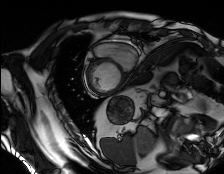

In [138]:
Image.open(query_image_path)

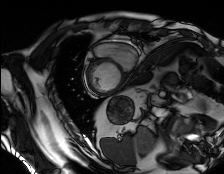

In [139]:
Image.open(top_n_similar_images[0])

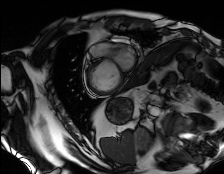

In [140]:
Image.open(top_n_similar_images[1])

In [141]:
similar_images_tensors = []
for path in top_n_similar_images[:2]:
    img = Image.open(path)
    similar_images_tensors.append(preprocess(img))
similar_images_tensors = torch.stack(similar_images_tensors, dim=0)  # shape: (N, 3, H, W)


top_n_similar_images_masks = [valid_masks[idx] for idx in most_similar_indices[:top_n]]

mask_tensors = []
for path in top_n_similar_images_masks[:2]:
    mask = Image.open(path).convert('L')  # assume grayscale masks
    mask = mask.resize((256, 256), resample=Image.NEAREST)
    mask_tensor = torch.from_numpy(np.array(mask)).long()
    mask_tensor = remap_labels(mask_tensor)  # using your remap_labels function
    mask_tensors.append(mask_tensor)
mask_tensors = torch.stack(mask_tensors, dim=0)  # shape: (N, H, W)


In [142]:
g1 = similar_images_tensors[0].unsqueeze(0)
g1 = similar_images_tensors[0].unsqueeze(0)

g_m1 = mask_tensors[0].unsqueeze(0)  
g_m2 = mask_tensors[0].unsqueeze(0) 

In [146]:
with torch.no_grad():
    # guide_image1, guide_image2, guide_mask1, guide_mask2 = joint_module(query_image, gallery_images, gallery_masks)
    composite_input = torch.cat([
        query_image.to(device),
        g1.to(device),
        g2.to(device),
        g_m1.unsqueeze(1).to(device),
        g_m2.unsqueeze(1).to(device),
    ], dim=1)
    
    pred_masks = segmentation_model(composite_input)
    pred_masks = torch.argmax(pred_masks, dim=1, keepdim=False)
    pred_masks = pred_masks.cpu().numpy()

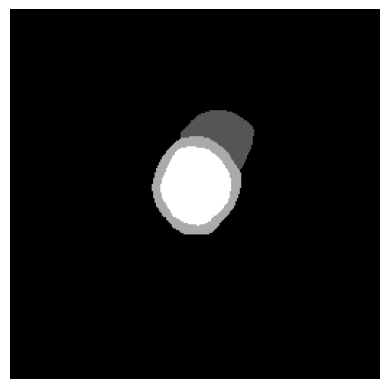

In [144]:
import matplotlib.pyplot as plt

# Assuming pred_masks is already a NumPy array of shape (256, 256)
plt.imshow(pred_masks.squeeze(0), cmap='gray')
plt.axis(False)
plt.show()


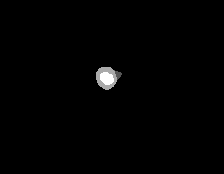

In [145]:
Image.open(valid_masks[valid_images.index(query_image_path)])